# Goal

* Train models to classify the 3 category qwerties

* Parameterically vary the depth of the models, while keeping the totoal number of units constant (80 in total).

* Parametrically vary the amount of data, from N=50 to 550

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Data

In [18]:
def create_data(n_per_clust):

  A = [1,1]
  B = [5,1]
  C = [4,4]

  a = [A[0]+np.random.randn(n_per_clust), A[1]+np.random.randn(n_per_clust)]
  b = [B[0]+np.random.randn(n_per_clust), B[1]+np.random.randn(n_per_clust)]
  c = [C[0]+np.random.randn(n_per_clust), C[1]+np.random.randn(n_per_clust)]

  labels_np = np.hstack((
      np.zeros((n_per_clust)),
      np.ones((n_per_clust)),
      1+np.ones((n_per_clust))
  ))

  data_np = np.hstack((a,b,c)).T

  #  put all outputs into a dictionary
  output = {}
  output['data'] = torch.tensor(data_np).float()
  output['labels'] = torch.tensor(labels_np).long()

  train_data, test_data, train_labels, test_labels = train_test_split(output['data'], output['labels'], test_size = .2)

  train_dataset = TensorDataset(train_data, train_labels)
  test_dataset = TensorDataset(test_data, test_labels)

  batch_size = 8
  output['train_data'] = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
  output['test_data'] = DataLoader(test_dataset, batch_size = test_data.shape[0])

  return output

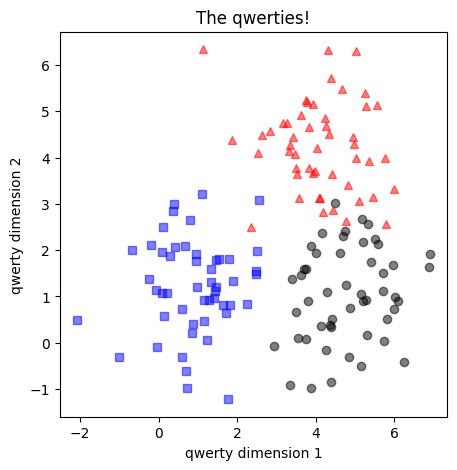

In [19]:
the_data = create_data(50)

data = the_data['data']
labels = the_data['labels']

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0],1], 'bs', alpha = .5)
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0],1], 'ko', alpha = .5)
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0],1], 'r^', alpha = .5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Create the Model

In [5]:
def create_net(n_units, n_layers):

  class qwerty_net(nn.Module):
    def __init__(self, n_units, n_layers):
      super().__init__()

      self.layers = nn.ModuleDict()
      self.n_layers = n_layers

      self.layers['input'] = nn.Linear(2, n_units)

      for i in range(n_layers):
        self.layers[f'hidden_{i}'] = nn.Linear(n_units, n_units)

      self.layers['output'] = nn.Linear(n_units, 3)

    def forward(self, x):
      x = self.layers['input'](x)

      for i in range(self.n_layers):
        x = F.relu(self.layers[f'hidden_{i}'](x))

      x = self.layers['output'](x)

      return x

  net = qwerty_net(n_units, n_layers)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = .01)

  return net, loss_fn, optimizer

In [20]:
n_units = 12
n_layers = 4

net, loss_fn, opt = create_net(n_units, n_layers)
print(net)

input = torch.rand(10, 2)
net(input)

qwerty_net(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=12, bias=True)
    (hidden_0): Linear(in_features=12, out_features=12, bias=True)
    (hidden_1): Linear(in_features=12, out_features=12, bias=True)
    (hidden_2): Linear(in_features=12, out_features=12, bias=True)
    (hidden_3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


tensor([[ 0.0462,  0.0275, -0.1021],
        [ 0.0465,  0.0298, -0.1024],
        [ 0.0464,  0.0340, -0.1044],
        [ 0.0448,  0.0385, -0.1106],
        [ 0.0460,  0.0336, -0.1054],
        [ 0.0454,  0.0389, -0.1092],
        [ 0.0466,  0.0254, -0.1000],
        [ 0.0463,  0.0285, -0.1022],
        [ 0.0464,  0.0326, -0.1037],
        [ 0.0452,  0.0391, -0.1099]], grad_fn=<AddmmBackward0>)

# Model Train

In [21]:
def ModelTrain(epochs, train_dataloader, test_dataloader, n_units, n_layers, verbose):
  net, loss_fn, optimizer = create_net(n_units, n_layers)

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []


    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

Epoch: 0 | Train Acc: 69.79 | Test Acc: 85.00 | Loss: 0.74
Epoch: 10 | Train Acc: 93.12 | Test Acc: 96.67 | Loss: 0.19
Epoch: 20 | Train Acc: 92.71 | Test Acc: 96.67 | Loss: 0.18
Epoch: 30 | Train Acc: 92.08 | Test Acc: 94.17 | Loss: 0.17
Epoch: 40 | Train Acc: 92.29 | Test Acc: 95.83 | Loss: 0.18
Epoch: 50 | Train Acc: 93.12 | Test Acc: 96.67 | Loss: 0.17
Epoch: 60 | Train Acc: 93.33 | Test Acc: 95.00 | Loss: 0.17
Epoch: 70 | Train Acc: 91.88 | Test Acc: 94.17 | Loss: 0.17
Epoch: 80 | Train Acc: 92.71 | Test Acc: 95.00 | Loss: 0.17
Epoch: 90 | Train Acc: 92.71 | Test Acc: 95.00 | Loss: 0.17
Epoch: 100 | Train Acc: 92.50 | Test Acc: 95.00 | Loss: 0.17
Epoch: 110 | Train Acc: 92.92 | Test Acc: 95.83 | Loss: 0.17
Epoch: 120 | Train Acc: 92.50 | Test Acc: 95.83 | Loss: 0.17
Epoch: 130 | Train Acc: 93.33 | Test Acc: 95.83 | Loss: 0.17
Epoch: 140 | Train Acc: 93.75 | Test Acc: 96.67 | Loss: 0.16
Epoch: 150 | Train Acc: 93.33 | Test Acc: 95.83 | Loss: 0.16
Epoch: 160 | Train Acc: 92.71 | Tes

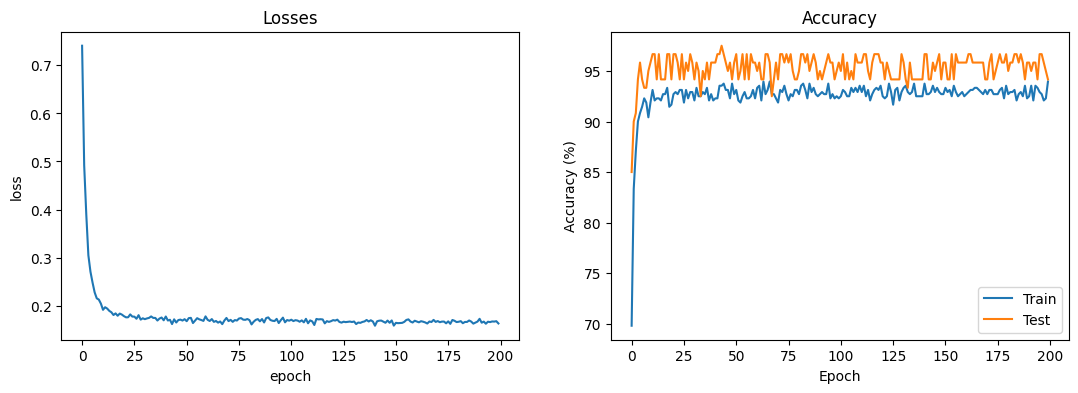

In [24]:
data = create_data(200)
train_data = data['train_data']
test_data = data['test_data']

train_acc, test_acc, losses = ModelTrain(epochs = 200,
                                         train_dataloader = train_data,
                                         test_dataloader = test_data,
                                         n_units = 80,
                                         n_layers = 1,
                                         verbose = True)

fig, ax = plt.subplots(1,2,figsize = (13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

# Experiment

We're going to keep the total n_nodes fixed, meaning if we get more layers we will get proportionally less n_nodes.

In [31]:
n_nodes_in_model = 80
layers_range = [1,5,10,20]
n_data_points = np.arange(50,551,50)

legend = []

for lidx, layers in enumerate(layers_range):
  units_per_layer = int(n_nodes_in_model / layers_range[lidx])
  net = create_net(units_per_layer, layers)[0]

  n_params = np.sum([p.numel() for p in net.parameters() if p.requires_grad])

  legend.append('%s layers, %s units, %s params' %(layers, units_per_layer, n_params))
  print('This model will have %s layers, each with %s units, totalling %s parameters' %(layers, units_per_layer, n_params))

This model will have 1 layers, each with 80 units, totalling 6963 parameters
This model will have 5 layers, each with 16 units, totalling 1459 parameters
This model will have 10 layers, each with 8 units, totalling 771 parameters
This model will have 20 layers, each with 4 units, totalling 427 parameters


In [38]:
results = np.zeros((len(n_data_points), len(layers_range), 2))

for didx, pnts in enumerate(n_data_points):
  the_data = create_data(pnts)
  train_data = the_data['train_data']
  test_data = the_data['test_data']

  for lidx, layers in enumerate(layers_range):
    print(f'\n\nPROCESSING: n_data_points: {pnts} layers: {layers}')
    units_per_layer = int(n_nodes_in_model/layers_range[lidx])
    train_acc, test_acc, losses = ModelTrain(epochs = 200,
                                             train_dataloader = train_data,
                                              test_dataloader = test_data,
                                              n_units = 80,
                                              n_layers = 1,
                                              verbose = True)

    results[didx, lidx, 0] = np.mean(test_acc[-5:])
    results[didx, lidx, 1] = torch.mean(losses[-5:]).item()



PROCESSING: n_data_points: 50 layers: 1
Epoch: 0 | Train Acc: 55.00 | Test Acc: 53.33 | Loss: 0.93
Epoch: 10 | Train Acc: 89.17 | Test Acc: 93.33 | Loss: 0.34
Epoch: 20 | Train Acc: 93.33 | Test Acc: 96.67 | Loss: 0.22
Epoch: 30 | Train Acc: 93.33 | Test Acc: 96.67 | Loss: 0.18
Epoch: 40 | Train Acc: 94.17 | Test Acc: 96.67 | Loss: 0.16
Epoch: 50 | Train Acc: 94.17 | Test Acc: 96.67 | Loss: 0.15
Epoch: 60 | Train Acc: 94.17 | Test Acc: 93.33 | Loss: 0.15
Epoch: 70 | Train Acc: 95.00 | Test Acc: 93.33 | Loss: 0.14
Epoch: 80 | Train Acc: 95.83 | Test Acc: 96.67 | Loss: 0.14
Epoch: 90 | Train Acc: 95.00 | Test Acc: 96.67 | Loss: 0.14
Epoch: 100 | Train Acc: 95.00 | Test Acc: 93.33 | Loss: 0.13
Epoch: 110 | Train Acc: 95.00 | Test Acc: 93.33 | Loss: 0.13
Epoch: 120 | Train Acc: 95.83 | Test Acc: 96.67 | Loss: 0.13
Epoch: 130 | Train Acc: 95.83 | Test Acc: 96.67 | Loss: 0.12
Epoch: 140 | Train Acc: 95.83 | Test Acc: 96.67 | Loss: 0.12
Epoch: 150 | Train Acc: 95.83 | Test Acc: 96.67 | Loss

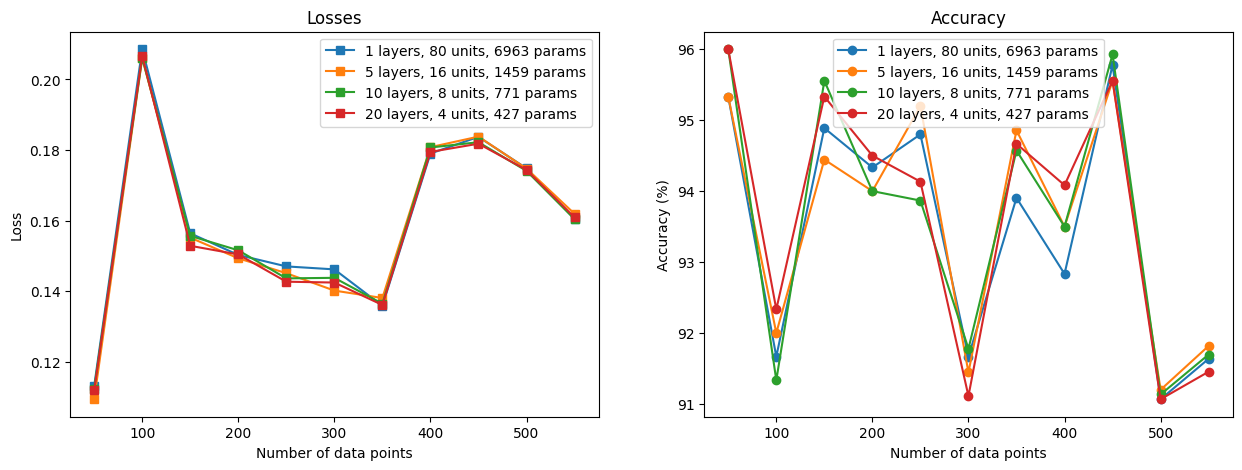

In [39]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(n_data_points, results[:,:,1], 's-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(n_data_points, results[:,:,0], 'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)
plt.show()